In [1]:
cd ..

C:\Users\guest0\joeran\M5Forecast\uncertainty


In [2]:
cd ..

C:\Users\guest0\joeran\M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

# import wandb
# from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, 
                  save_object, load_object)
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [4]:
def run_experiment(nodes_settings, mode="dense"):
    """
    Run experiment on the performance of the final "distribution layer"
    nodes_settings: number of nodes per layer to test
                    should be in the format {level: [n1, n2, ...], ...}
    mode: distribution layer to test, either "dense", "dist2", "dist4" or "direct"
    """
    
    # setup model builder function
    if mode == "dense":
        model_func = get_simple_dense_model
    elif mode == "dist2":
        model_func = get_simple_dist_model
    elif mode == "dist4":
        model_func = get_variable_dist_model
    elif mode == "direct":
        model_func = get_direct_dist_model
    
    # track metrics
    logger_list = []
    part1_metrics = []
    part2_metrics = []
    part3_metrics = []
    
    # loop over the levels
    for level, node_options in nodes_settings.items():
        
        # loop over the number of nodes per layer
        for num_nodes in node_options:
            model_name = "model_{}_{}".format(mode, num_nodes)
            
            # build model
            model = model_func(inp_shape=input_shapes[level], num_nodes=num_nodes, final_activation="exponential")
            model.summary()
            
            # train model
            warmup_lr_list = [1e-3, 1e-3, 1e-3, # save part 1
                              1e-3, 1e-3, 1e-3] # save part 2
            finetune_lr_list = [1e-4, 1e-4, 1e-5, 1e-5]
            model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
                level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
                model_dir=model_dir, model_name=model_name, warmup_lr_list=warmup_lr_list, 
                finetune_lr_list=finetune_lr_list)
            
            # save metrics
            logger_list.append(logger); part1_metrics.append(metrics1); 
            part2_metrics.append(metrics2); part3_metrics.append(metrics3)
            for i, m in enumerate([part1_metrics, part2_metrics, part3_metrics]):
                save_object(m, model_dir + mode + "_part{}_metrics.pickle".format(i+1))
            
            # save training metrics
            save_object(logger.train_metrics, model_dir + model_name + "_metrics_train.pickle")
            save_object(logger.val_metrics, model_dir + model_name + "_metrics_val.pickle")

# Train MLP - multiple levels

In [5]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [6]:
model_dir = 'models/uncertainty/experiment/run4/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Define model architectures

In [7]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,),
}

# Set initial batch size
warmup_batch_size = {level: 64 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 256 if level <= 9 else 25000 for level in range(1, 1+12)}

## Define experiment settings

In [8]:
def get_nodes_settings(mode):
    nodes_dense_small = [256, 512, 1024]#2, 4, 8, 16, 32, 64, 128]
    nodes_dist2_small = [64, 128, 256]#1, 2, 4, 6, 8, 16, 32]
    nodes_dist4_small = [64, 128, 256]#1, 2, 4, 6, 8, 16, 32]
    nodes_direct_small = [64, 128, 256]#1, 2, 4, 6, 8, 16, 32]
    
    # setup node settings
    if mode == "dense":
        nodes_settings = {level: nodes_dense_small for level in range(10, 12+1)}
    elif mode == "dist2":
        nodes_settings = {level: nodes_dist2_small for level in range(10, 12+1)}
    elif mode == "dist4":
        nodes_settings = {level: nodes_dist4_small for level in range(10, 12+1)}
    elif mode == "direct":
        nodes_settings = {level: nodes_direct_small for level in range(10, 12+1)}

    return nodes_settings

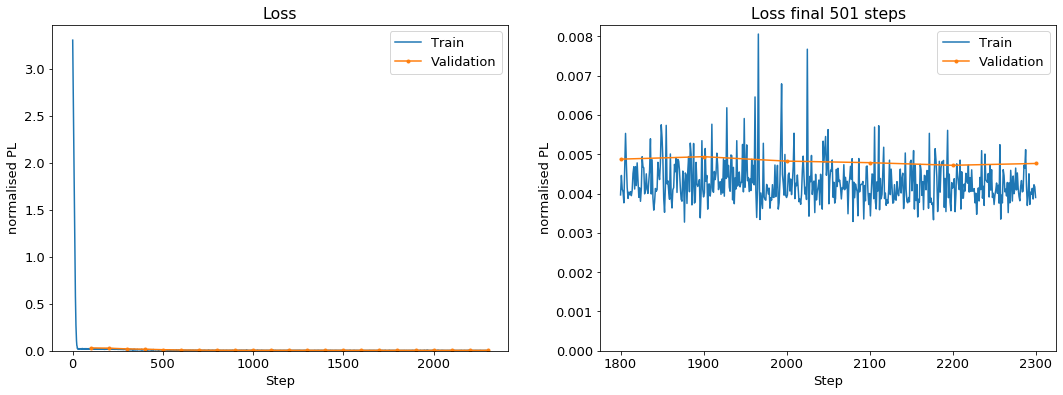

100/100 [==============================] - 13s 132ms/step - loss: 0.0042 - q0_loss: 2.4070e-05 - q1_loss: 1.1526e-04 - q2_loss: 5.4023e-04 - q3_loss: 7.0119e-04 - q4_loss: 9.4814e-04 - q5_loss: 8.3899e-04 - q6_loss: 6.9854e-04 - q7_loss: 2.2577e-04 - q8_loss: 8.0255e-05 - val_loss: 0.0048 - val_q0_loss: 3.5314e-05 - val_q1_loss: 1.7187e-04 - val_q2_loss: 6.4827e-04 - val_q3_loss: 8.3737e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.2816e-04 - val_q6_loss: 7.5626e-04 - val_q7_loss: 2.2327e-04 - val_q8_loss: 6.6840e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.0041 - q0_loss: 2.4011e-05 - q1_loss: 1.1498e-04 - q2_loss: 5.3645e-04 - q3_loss: 6.9601e-04 - q4_loss: 9.3737e-04 - q5_loss: 8.2503e-04 - q6_loss: 6.8859e-04 - q7_loss: 2.3061e-04 - q8_loss: 9.1186e-05

In [ ]:
for mode in ["direct", "dist2", "dist4", "dense"]:
    print("Starting mode {}..".format(mode))
    
    nodes_settings = get_nodes_settings(mode)
    print(nodes_settings)
    
    run_experiment(nodes_settings, mode=mode)

## Test reading